In [9]:
# ===========================
# 1. Data Loading & Encoding
# ===========================
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load dataset (CSV columns include both categorical and numeric features, with 'algo' target)
data = pd.read_csv("final_merged_dataset.csv")

# Separate features and target
X = data.drop(columns=['algo','algo_type'])  # drop algorithm columns
y = data['algo']                             # target encryption algorithm

# Encode categorical features to numeric labels
cat_cols = ['sensitivity','transit','latency','RNG Type','SCA Resistance','Design Method','Security Level']
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Encode target labels
y = LabelEncoder().fit_transform(y)

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
# ===========================
# 2. Train Models
# ===========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)                   # Train model
    preds = model.predict(X_test)                 # Predict on test set
    acc = accuracy_score(y_test, preds)
    print(f"{name} Test Accuracy: {acc:.2f}")
    print(classification_report(y_test, preds))
    results[name] = acc



Decision Tree Test Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Random Forest Test Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

XGBoost Test Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.0

e:\cuda\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


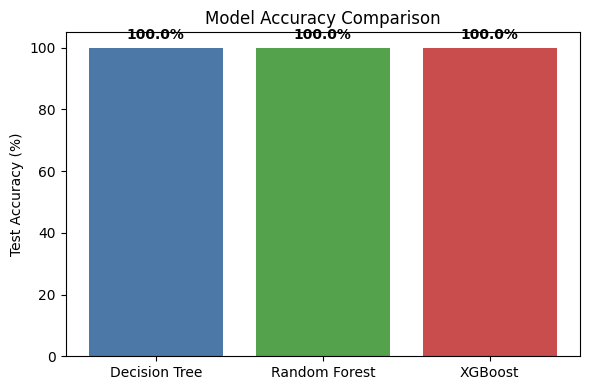

In [11]:
# ===========================
# 3. Plot Accuracies
# ===========================
import matplotlib.pyplot as plt

# Bar chart of accuracies (for visualization in report)
model_names = list(results.keys())
acc_values = [results[n]*100 for n in model_names]
plt.figure(figsize=(6,4))
bars = plt.bar(model_names, acc_values, color=['#4c78a8','#54a24b','#c94d4d'])
plt.ylim(0, 105)
plt.ylabel('Test Accuracy (%)')
plt.title('Model Accuracy Comparison')
for i,v in enumerate(acc_values):
    plt.text(i, v+3, f"{v:.1f}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png")


In [ ]:
import oqs

# Example: choose algorithm (predicted by ML model) or fallback to RSA if unknown
chosen_algo = model.predict(X_new)[0]  # e.g. "Kyber512"
if chosen_algo not in ["Kyber512", "Dilithium3"]:
    chosen_algo = "RSA-2048"  # fallback (classical)

if chosen_algo.startswith("Kyber"):
    # Key encapsulation with Kyber512
    kem = oqs.KeyEncapsulation(chosen_algo)
    public_key, secret_key = kem.generate_keypair()
    ciphertext, shared_secret = kem.encap_secret(public_key)
    # The receiver would then decapsulate:
    received_secret = kem.decapsulate(ciphertext, secret_key)
    assert shared_secret == received_secret
    print("Data encrypted (shared key established) with", chosen_algo)
elif chosen_algo.startswith("Dilithium"):
    # Dilithium is a signature algorithm; demonstrate signing instead
    sig = oqs.Signature(chosen_algo)
    public_key, secret_key = sig.generate_keypair()
    message = b"Example transaction data"
    signature = sig.sign(message, secret_key)
    valid = sig.verify(message, signature, public_key)
    print("Data signed with", chosen_algo, "; signature valid?", valid)
else:
    # Fallback RSA encryption (using PyCryptodome as example)
    from Cryptodome.PublicKey import RSA
    from Cryptodome.Cipher import PKCS1_OAEP
    key = RSA.generate(2048)
    cipher = PKCS1_OAEP.new(key.publickey())
    message = b"Example transaction data"
    ciphertext = cipher.encrypt(message)
    # Decrypt to verify
    decrypted = PKCS1_OAEP.new(key).decrypt(ciphertext)
    print("Data encrypted with RSA-2048")


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# 1. Load data
data = pd.read_csv('final_merged_dataset.csv')

# 2. Encode categorical columns
cat_cols = ['sensitivity', 'transit', 'latency', 'RNG Type', 'SCA Resistance', 'Design Method', 'Security Level']
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# 3. Features & target
X = data.drop(columns=['algo', 'algo_type'])
y = LabelEncoder().fit_transform(data['algo'])

# 4. Cross-validation on small dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")


Logistic Regression mean CV accuracy: 1.00 (+/- 0.00)
Naive Bayes mean CV accuracy: 1.00 (+/- 0.00)


In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset with correct encoding
df = pd.read_csv("kyber_dilithium_rsa_dataset.csv", encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip()

# Drop missing values (or fillna if preferred)
df.dropna(inplace=True)

# Label encode target column
target_col = 'algo'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col].astype(str))

# Split into features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode all categorical feature columns
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# Optional: Map predictions back to original labels
inv_label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("\nSample Predictions (mapped):")
for i in range(5):
    print(f"Predicted: {inv_label_map[rf_preds[i]]}, Actual: {inv_label_map[y_test.iloc[i]]}")


Random Forest Accuracy: 1.0

Sample Predictions (mapped):
Predicted: Kyber768, Actual: Kyber768
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score

# Load dataset with correct encoding
df = pd.read_csv("kyber_dilithium_rsa_dataset.csv", encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Encode target column
target_col = 'algo'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col].astype(str))

# Encode categorical features
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
print("GaussianNB Accuracy:", accuracy_score(y_test, gnb_preds))

# Bernoulli Naive Bayes (works better with binary features)
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
print("BernoulliNB Accuracy:", accuracy_score(y_test, bnb_preds))

# Optional: Map predictions back to algorithm names
inv_label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("\nSample Predictions (GaussianNB):")
for i in range(5):
    print(f"Predicted: {inv_label_map[gnb_preds[i]]}, Actual: {inv_label_map[y_test.iloc[i]]}")


GaussianNB Accuracy: 1.0
BernoulliNB Accuracy: 0.3333333333333333

Sample Predictions (GaussianNB):
Predicted: Kyber768, Actual: Kyber768
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Load dataset with correct encoding
df = pd.read_csv("kyber_dilithium_rsa_dataset.csv", encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Encode target column
target_col = 'algo'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col].astype(str))

# Encode categorical features
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
print("GaussianNB Accuracy:", accuracy_score(y_test, gnb_preds))

# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
print("BernoulliNB Accuracy:", accuracy_score(y_test, bnb_preds))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

# CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))

# Inverse label mapping
inv_label_map = dict(zip(le.transform(le.classes_), le.classes_))

# Show sample predictions
print("\nSample Predictions (CatBoost):")
for i in range(5):
    print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")


GaussianNB Accuracy: 1.0
BernoulliNB Accuracy: 0.3333333333333333
Logistic Regression Accuracy: 1.0
CatBoost Accuracy: 1.0

Sample Predictions (CatBoost):
Predicted: Kyber768, Actual: Kyber768
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512


C:\Users\Prathamesh Shetty\AppData\Local\Temp\ipykernel_24292\4149793145.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv("./kyber_dilithium_rsa_dataset.csv", encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Encode target column
target_col = 'algo'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col].astype(str))

# Encode categorical features
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Identify numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Add Gaussian noise to numerical features
noise_factor = 0.01
X[num_cols] = X[num_cols] + noise_factor * np.random.randn(*X[num_cols].shape)

# Scale features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions using PCA
pca = PCA(n_components=0.95)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
print("GaussianNB Accuracy:", accuracy_score(y_test, gnb_preds))

# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
print("BernoulliNB Accuracy:", accuracy_score(y_test, bnb_preds))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

# CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))

# Inverse label mapping
inv_label_map = dict(zip(le.transform(le.classes_), le.classes_))

# Show sample predictions
print("\nSample Predictions (CatBoost):")
for i in range(5):
    print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")


GaussianNB Accuracy: 1.0
BernoulliNB Accuracy: 1.0
Logistic Regression Accuracy: 1.0
CatBoost Accuracy: 1.0

Sample Predictions (CatBoost):
Predicted: Kyber768, Actual: Kyber768
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512


C:\Users\Prathamesh Shetty\AppData\Local\Temp\ipykernel_24292\336232114.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")


In [22]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Sample simulated dataset
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_classes=3,
    class_sep=2.0,  # Lower this to simulate harder classification
    random_state=42
)

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print("📊 Classification Report:")
    print(classification_report(y_val, y_pred))
    print("🧾 Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))



🔁 Fold 1
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        66
           1       0.96      1.00      0.98        67
           2       1.00      0.94      0.97        67

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

🧾 Confusion Matrix:
[[66  0  0]
 [ 0 67  0]
 [ 1  3 63]]

🔁 Fold 2
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       1.00      0.94      0.97        67
           2       0.92      1.00      0.96        67

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.97      0.96      0.97       200

🧾 Confusion Matrix:
[[63  0  3]
 [ 1 63  3]
 [ 0  0 67]]

🔁 Fold 3
📊 Classification Report:
              preci

In [23]:
# Domain A (e.g., Kyber-like data)
X_kyber, y_kyber = make_classification(
    n_samples=800,
    n_features=10,
    n_informative=6,
    n_classes=3,
    class_sep=2.0,
    random_state=1
)

# Domain B (e.g., NTRU-like test set)
X_ntru, y_ntru = make_classification(
    n_samples=200,
    n_features=10,
    n_informative=6,
    n_classes=3,
    class_sep=1.0,  # Make it harder
    random_state=5
)

X_kyber = scaler.fit_transform(X_kyber)
X_ntru = scaler.transform(X_ntru)

model.fit(X_kyber, y_kyber)
y_pred_ntru = model.predict(X_ntru)

print("📡 Cross-Domain Test (Kyber ➜ NTRU):")
print(classification_report(y_ntru, y_pred_ntru))


📡 Cross-Domain Test (Kyber ➜ NTRU):
              precision    recall  f1-score   support

           0       0.24      0.18      0.21        67
           1       0.32      0.43      0.37        67
           2       0.22      0.20      0.21        66

    accuracy                           0.27       200
   macro avg       0.26      0.27      0.26       200
weighted avg       0.26      0.27      0.26       200



In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
import numpy as np


GaussianNB Accuracy: 1.0
BernoulliNB Accuracy: 0.125
Logistic Regression Accuracy: 1.0


e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CatBoost Accuracy: 1.0

Sample Predictions (CatBoost):
Predicted: Kyber512, Actual: Kyber512
Predicted: SPHINCS+, Actual: SPHINCS+
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512
Predicted: Kyber512, Actual: Kyber512


C:\Users\Prathamesh Shetty\AppData\Local\Temp\ipykernel_24292\2693232518.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")


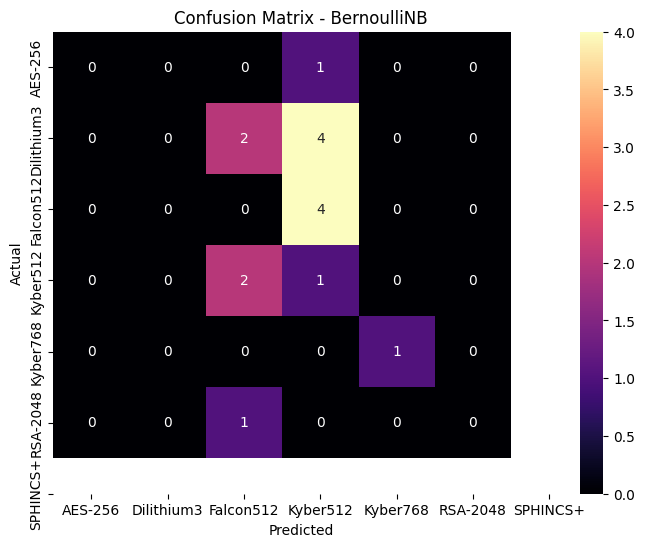

e:\cuda\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


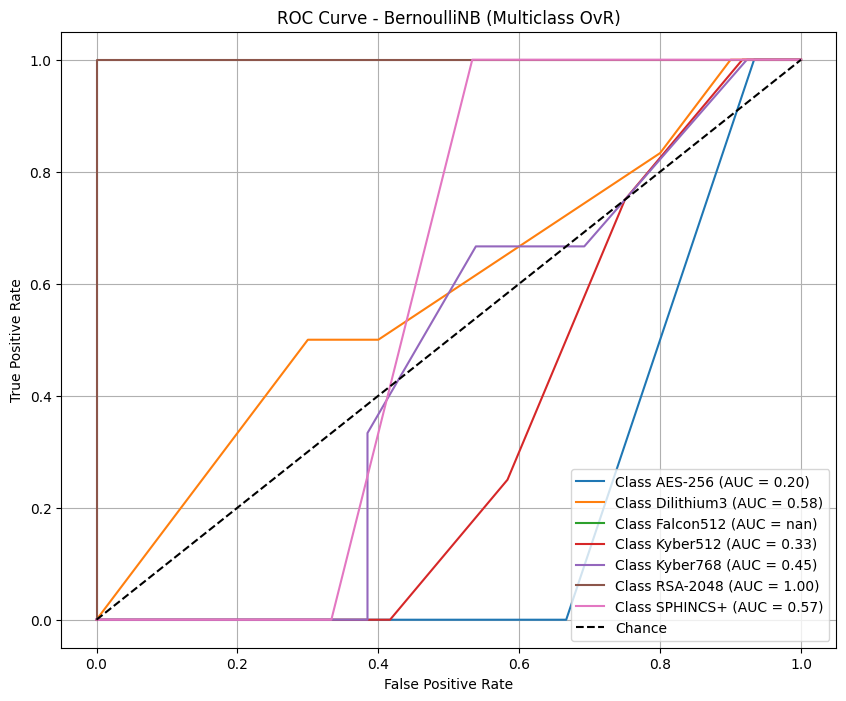

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Load dataset with correct encoding
df = pd.read_csv("kyber_dilithium_rsa_dataset.csv", encoding='ISO-8859-1')

# Clean column names
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Encode target column
target_col = 'algo'
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col].astype(str))

# Encode categorical features
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)
print("GaussianNB Accuracy:", accuracy_score(y_test, gnb_preds))

# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_preds = bnb.predict(X_test)
print("BernoulliNB Accuracy:", accuracy_score(y_test, bnb_preds))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

# CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))

# Inverse label mapping
inv_label_map = dict(zip(le.transform(le.classes_), le.classes_))

# Show sample predictions
print("\nSample Predictions (CatBoost):")
for i in range(5):
    print(f"Predicted: {inv_label_map[int(cat_preds[i])]}, Actual: {inv_label_map[y_test.iloc[i]]}")

# Heatmap (Confusion Matrix) for BernoulliNB
cm = confusion_matrix(y_test, bnb_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - BernoulliNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and AUC Curve (One-vs-Rest)
# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

bnb_ovr = OneVsRestClassifier(BernoulliNB())
bnb_ovr.fit(X_train, label_binarize(y_train, classes=np.unique(y)))
y_score = bnb_ovr.predict_proba(X_test)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {inv_label_map[i]} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.title('ROC Curve - BernoulliNB (Multiclass OvR)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Load data
df = pd.read_csv('kyber_dilithium_rsa_dataset.csv')

# -------- Preprocessing --------

# 1. Mark PQC hardware fields as zero for "RSA-2048" and "AES-256" fallback cases
# This step assumes columns like BRAMs/LUTs etc exist in data
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)', 
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)', 
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)', 
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles', 'ct_size', 'key_size']
for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

# 2. Fill missing values (you can refine this)
df = df.fillna(0)

# 3. Encode all categorical features
categoricals = []
for col in df.columns:
    if df[col].dtype == 'object' and col != 'algo':
        categoricals.append(col)

for col in categoricals:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 4. Features and target
X = df.drop(columns=['algo', 'algo_type'])  # Remove target/aux fields
y = LabelEncoder().fit_transform(df['algo'])  # Multiclass: PQC + fallback

# -------- Model Training & Evaluation --------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "GaussianNB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.91 (+/- 0.03)
GaussianNB mean CV accuracy: 0.93 (+/- 0.00)
Decision Tree mean CV accuracy: 0.89 (+/- 0.03)


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# -----------------------------------------
# Step 1: Load your synthesized dataset CSV
# Replace 'your_dataset.csv' with your actual filename
df = pd.read_csv('./kyber_dilithium_rsa_dataset.csv')

# -----------------------------------------
# Step 2: Add noise to the dataset

np.random.seed(42)  # reproducibility

# Parameters for noise intensity
numeric_noise_level = 0.05       # 5% noise relative to mean value
categorical_noise_fraction = 0.05  # 5% of categorical values randomized
label_noise_fraction = 0.01      # 1% labels flipped - optional

# 2.1 Identify numeric columns (excluding IDs or certain discrete fields)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_numeric = ['key_size', 'ct_size']  # Discrete fields - exclude if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_numeric]

for col in numeric_cols:
    col_mean = df[col].mean()
    noise_scale = numeric_noise_level * col_mean
    noise = np.random.normal(loc=0, scale=noise_scale, size=df.shape[0])
    df[col] = df[col] + noise
    # Round integers back where necessary
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype(int)

# 2.2 Add noise to categorical columns except target ('algo')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'algo' in categorical_cols:
    categorical_cols.remove('algo')

for col in categorical_cols:
    n_noisy = int(len(df) * categorical_noise_fraction)
    indices = np.random.choice(df.index, n_noisy, replace=False)
    unique_vals = df[col].unique()
    for i in indices:
        current_val = df.at[i, col]
        other_vals = [val for val in unique_vals if val != current_val]
        df.at[i, col] = np.random.choice(other_vals)

# 2.3 Optional: Flip some labels to add label noise
n_label_flip = int(len(df) * label_noise_fraction)
if n_label_flip > 0:
    indices = np.random.choice(df.index, n_label_flip, replace=False)
    unique_labels = df['algo'].unique()
    for i in indices:
        current_label = df.at[i, 'algo']
        other_labels = [label for label in unique_labels if label != current_label]
        df.at[i, 'algo'] = np.random.choice(other_labels)

print("Noise added to dataset.")

# -----------------------------------------
# Step 3: Preprocessing before model training

# 3.1 Hardware fallback: Set hardware resource columns to zero for 'RSA-2048' or 'AES-256'
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)', 
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)', 
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)', 
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles', 'ct_size', 'key_size']

for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

# 3.2 Fill missing values as zero (or use another strategy)
df = df.fillna(0)

# 3.3 Encode categorical features (excluding target 'algo' for now)
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 3.4 Encode target labels
y = LabelEncoder().fit_transform(df['algo'])

# 3.5 Prepare feature matrix X (drop target and optionally 'algo_type' if present)
X = df.drop(columns=['algo'])
if 'algo_type' in X.columns:
    X = X.drop(columns=['algo_type'])

# -----------------------------------------
# Step 4: Train and evaluate models using 5-fold Stratified CV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=0.1),    # with regularization
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=42)
}

print("\nModel evaluation with noisy dataset:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")


Noise added to dataset.

Model evaluation with noisy dataset:


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.842 (+/- 0.034)
Gaussian Naive Bayes mean CV accuracy: 0.934 (+/- 0.002)
Decision Tree mean CV accuracy: 0.842 (+/- 0.069)


e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cud

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

# -----------------------------------------
# Step 1: Load your synthesized dataset CSV
# Replace 'your_dataset.csv' with your actual filename
df = pd.read_csv('./kyber_dilithium_rsa_dataset.csv')

# -----------------------------------------
# Step 2: Add noise to the dataset

np.random.seed(42)  # reproducibility

# Parameters for noise intensity
numeric_noise_level = 0.05       # 5% noise relative to mean value
categorical_noise_fraction = 0.05  # 5% of categorical values randomized
label_noise_fraction = 0.01      # 1% labels flipped - optional

# 2.1 Identify numeric columns (excluding IDs or certain discrete fields)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_numeric = ['key_size', 'ct_size']  # Discrete fields - exclude if needed
numeric_cols = [col for col in numeric_cols if col not in exclude_numeric]

for col in numeric_cols:
    col_mean = df[col].mean()
    noise_scale = numeric_noise_level * col_mean
    noise = np.random.normal(loc=0, scale=noise_scale, size=df.shape[0])
    df[col] = df[col] + noise
    # Round integers back where necessary
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype(int)

# 2.2 Add noise to categorical columns except target ('algo')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'algo' in categorical_cols:
    categorical_cols.remove('algo')

for col in categorical_cols:
    n_noisy = int(len(df) * categorical_noise_fraction)
    indices = np.random.choice(df.index, n_noisy, replace=False)
    unique_vals = df[col].unique()
    for i in indices:
        current_val = df.at[i, col]
        other_vals = [val for val in unique_vals if val != current_val]
        df.at[i, col] = np.random.choice(other_vals)

# 2.3 Optional: Flip some labels to add label noise
n_label_flip = int(len(df) * label_noise_fraction)
if n_label_flip > 0:
    indices = np.random.choice(df.index, n_label_flip, replace=False)
    unique_labels = df['algo'].unique()
    for i in indices:
        current_label = df.at[i, 'algo']
        other_labels = [label for label in unique_labels if label != current_label]
        df.at[i, 'algo'] = np.random.choice(other_labels)

print("Noise added to dataset.")

# -----------------------------------------
# Step 3: Preprocessing before model training

# 3.1 Hardware fallback: Set hardware resource columns to zero for 'RSA-2048' or 'AES-256'
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)', 
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)', 
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)', 
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles', 'ct_size', 'key_size']

for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

# 3.2 Fill missing values as zero (or use another strategy)
df = df.fillna(0)

# 3.3 Encode categorical features (excluding target 'algo' for now)
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 3.4 Encode target labels
y = LabelEncoder().fit_transform(df['algo'])

# 3.5 Prepare feature matrix X (drop target and optionally 'algo_type' if present)
X = df.drop(columns=['algo'])
if 'algo_type' in X.columns:
    X = X.drop(columns=['algo_type'])

# -----------------------------------------
# Step 4: Train and evaluate models using 5-fold Stratified CV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=0.1),    # with regularization
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=42)
}

print("\nModel evaluation with noisy dataset:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")


Noise added to dataset.

Model evaluation with noisy dataset:


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.842 (+/- 0.034)
Gaussian Naive Bayes mean CV accuracy: 0.934 (+/- 0.002)
Bernoulli Naive Bayes mean CV accuracy: 0.341 (+/- 0.055)
Decision Tree mean CV accuracy: 0.842 (+/- 0.069)


e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cud


Model evaluation with noisy dataset:


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.842 (+/- 0.034)
Gaussian Naive Bayes mean CV accuracy: 0.934 (+/- 0.002)
Bernoulli Naive Bayes mean CV accuracy: 0.341 (+/- 0.055)
Decision Tree mean CV accuracy: 0.842 (+/- 0.069)


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


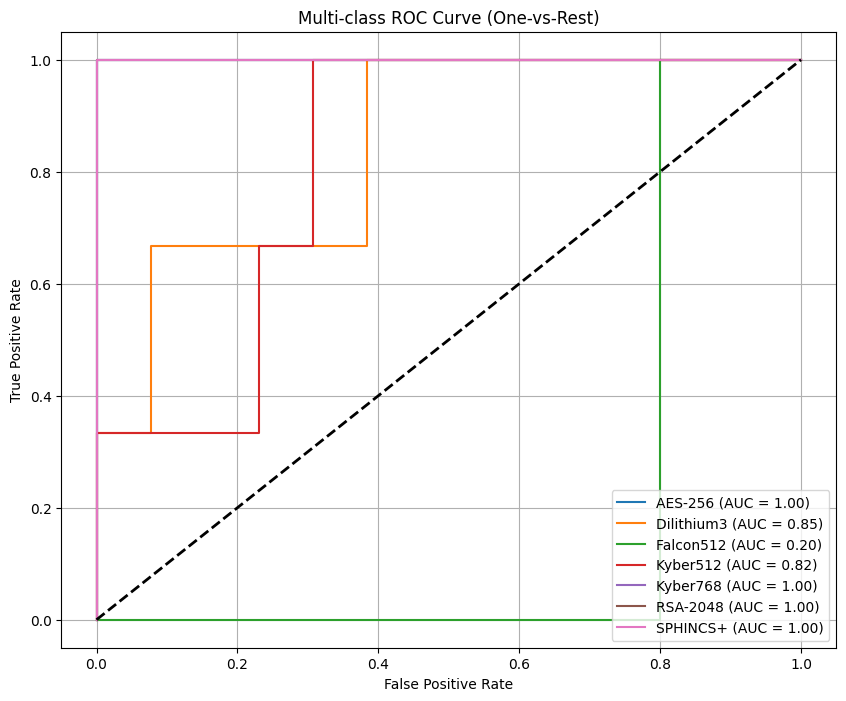

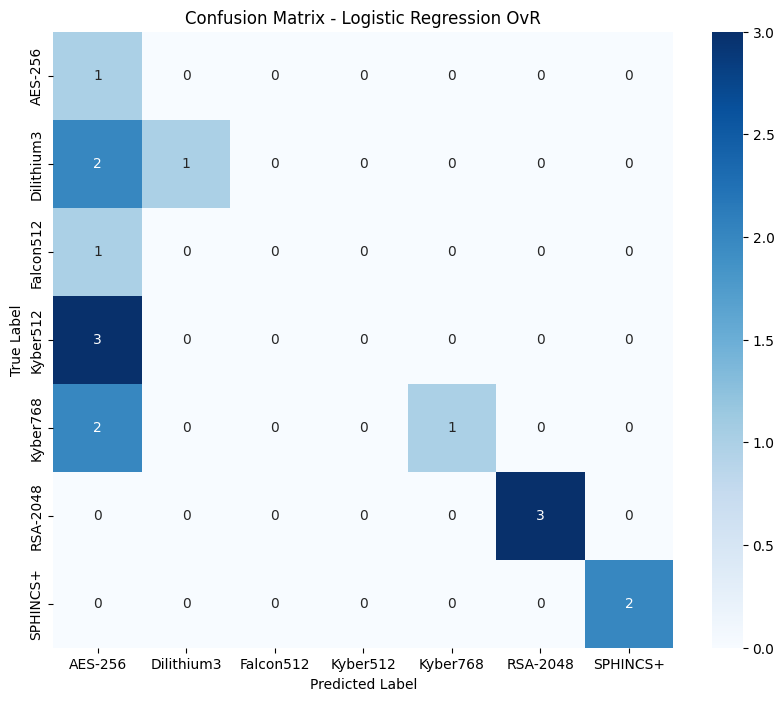

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

# -----------------------------------------
# Step 1: Load Dataset
df = pd.read_csv('./kyber_dilithium_rsa_dataset.csv')

# -----------------------------------------
# Step 2: Add Noise
np.random.seed(42)
numeric_noise_level = 0.05
categorical_noise_fraction = 0.05
label_noise_fraction = 0.01

# Numeric noise
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_numeric = ['key_size', 'ct_size']
numeric_cols = [col for col in numeric_cols if col not in exclude_numeric]

for col in numeric_cols:
    col_mean = df[col].mean()
    noise_scale = numeric_noise_level * col_mean
    noise = np.random.normal(0, noise_scale, size=df.shape[0])
    df[col] = df[col] + noise
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype(int)

# Categorical noise (except 'algo')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'algo' in categorical_cols:
    categorical_cols.remove('algo')

for col in categorical_cols:
    n_noisy = int(len(df) * categorical_noise_fraction)
    indices = np.random.choice(df.index, n_noisy, replace=False)
    unique_vals = df[col].unique()
    for i in indices:
        current_val = df.at[i, col]
        other_vals = [val for val in unique_vals if val != current_val]
        df.at[i, col] = np.random.choice(other_vals)

# Label noise
n_label_flip = int(len(df) * label_noise_fraction)
if n_label_flip > 0:
    indices = np.random.choice(df.index, n_label_flip, replace=False)
    unique_labels = df['algo'].unique()
    for i in indices:
        current_label = df.at[i, 'algo']
        other_labels = [label for label in unique_labels if label != current_label]
        df.at[i, 'algo'] = np.random.choice(other_labels)

# -----------------------------------------
# Step 3: Preprocessing
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)',
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)',
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)',
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles',
                       'ct_size', 'key_size']

for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

df = df.fillna(0)

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['algo'])

X = df.drop(columns=['algo'])
if 'algo_type' in X.columns:
    X = X.drop(columns=['algo_type'])

# -----------------------------------------
# Step 4: Train + Evaluate Models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=0.1),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=42)
}

print("\nModel evaluation with noisy dataset:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")

# -----------------------------------------
# Step 5: ROC Curve and Confusion Matrix (Logistic Regression OvR)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
ovr_model.fit(X_train_scaled, y_train_bin)
y_score = ovr_model.predict_proba(X_test_scaled)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{target_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix
y_pred = target_encoder.inverse_transform(np.argmax(ovr_model.predict(X_test_scaled), axis=1))
true_labels = target_encoder.inverse_transform(y_test)

conf_mat = confusion_matrix(true_labels, y_pred, labels=target_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression OvR")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Noise added to dataset.

Model evaluation with noisy dataset:


e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

Logistic Regression mean CV accuracy: 0.842 (+/- 0.034)
Bernoulli Naive Bayes mean CV accuracy: 0.341 (+/- 0.055)
Decision Tree mean CV accuracy: 0.842 (+/- 0.069)


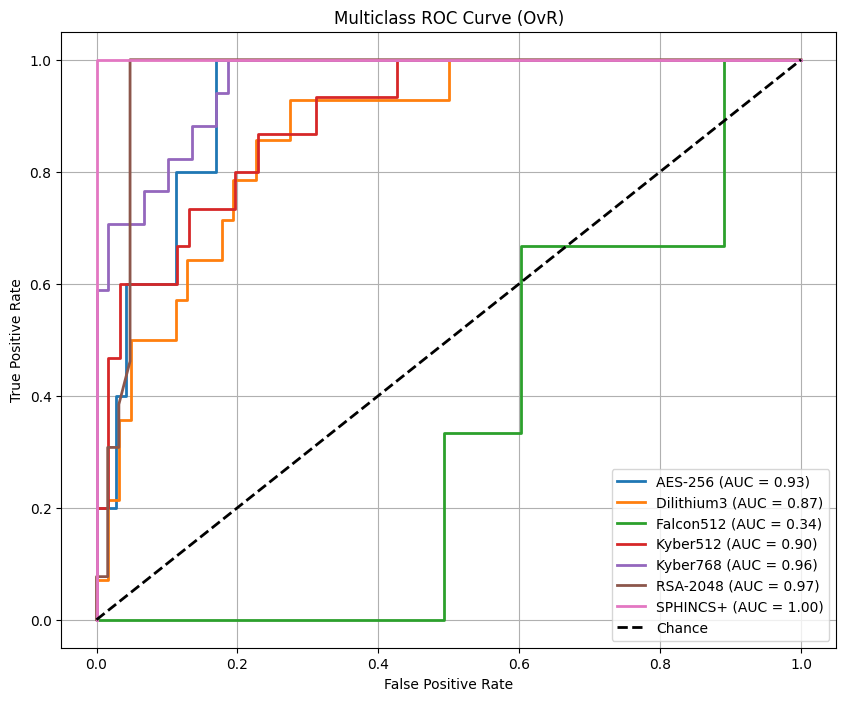

e:\cuda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


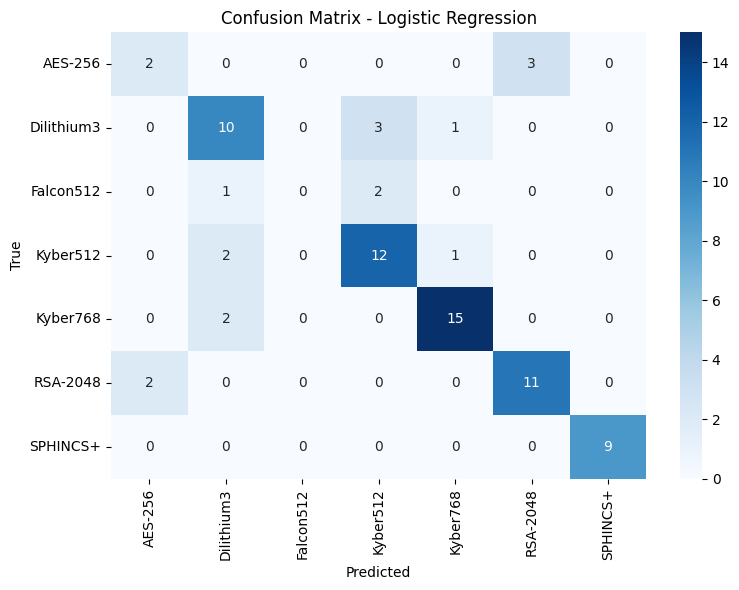

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

# -----------------------------------------
# Step 1: Load Dataset
df = pd.read_csv('./kyber_dilithium_rsa_dataset.csv')

# -----------------------------------------
# Step 2: Add Noise

np.random.seed(42)
numeric_noise_level = 0.05
categorical_noise_fraction = 0.05
label_noise_fraction = 0.01

# Numeric noise
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
exclude_numeric = ['key_size', 'ct_size']
numeric_cols = [col for col in numeric_cols if col not in exclude_numeric]

for col in numeric_cols:
    col_mean = df[col].mean()
    noise_scale = numeric_noise_level * col_mean
    noise = np.random.normal(0, noise_scale, size=df.shape[0])
    df[col] = df[col] + noise
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = df[col].round().astype(int)

# Categorical noise (except 'algo')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'algo' in categorical_cols:
    categorical_cols.remove('algo')

for col in categorical_cols:
    n_noisy = int(len(df) * categorical_noise_fraction)
    indices = np.random.choice(df.index, n_noisy, replace=False)
    unique_vals = df[col].unique()
    for i in indices:
        current_val = df.at[i, col]
        other_vals = [val for val in unique_vals if val != current_val]
        df.at[i, col] = np.random.choice(other_vals)

# Label noise
n_label_flip = int(len(df) * label_noise_fraction)
if n_label_flip > 0:
    indices = np.random.choice(df.index, n_label_flip, replace=False)
    unique_labels = df['algo'].unique()
    for i in indices:
        current_label = df.at[i, 'algo']
        other_labels = [label for label in unique_labels if label != current_label]
        df.at[i, 'algo'] = np.random.choice(other_labels)

print("Noise added to dataset.")

# -----------------------------------------
# Step 3: Preprocessing

# Zero hardware columns for fallback (RSA/AES)
hw_resource_columns = ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Freq (MHz)',
                       'Cycles (Enc/Sign)', 'Latency (μs)', 'Throughput (ops/s)',
                       'Power (mW)', 'Energy (μJ/op)', 'NTT Latency (cycles)',
                       'Twiddle ROM', 'keygen', 'enc', 'dec', 'cpu_cycles',
                       'ct_size', 'key_size']

for col in hw_resource_columns:
    if col in df.columns:
        df.loc[df['algo'].isin(['RSA-2048', 'AES-256']), col] = 0

# Fill missing
df = df.fillna(0)

# Encode categorical
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['algo'])

# Drop target and algo_type if exists
X = df.drop(columns=['algo'])
if 'algo_type' in X.columns:
    X = X.drop(columns=['algo_type'])

# -----------------------------------------
# Step 4: Train + Evaluate Models

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, C=0.1),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=42)
}

print("\nModel evaluation with noisy dataset:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"{name} mean CV accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")

# -----------------------------------------
# Step 5: ROC Curve and Confusion Matrix (Logistic Regression)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Binarize labels
classes = np.unique(y)
y_binarized = label_binarize(y, classes=classes)
n_classes = y_binarized.shape[1]

# ROC Curve (OvR)
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
y_score = cross_val_predict(ovr_model, X_scaled, y, cv=cv, method='predict_proba')

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{target_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix
y_pred = cross_val_predict(LogisticRegression(max_iter=1000, random_state=42), X_scaled, y, cv=cv)
conf_mat = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

